In [51]:
# Our custom module
from nn import DeepQNetwork
from custom_parking_env import ParkingWithObstacles
from relay_mem import ReplayMemory,Transition

# python module
import gymnasium as gym
import torch
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from itertools import count
from IPython import display

# combine observation
def process_observation(observation):
    observation_vector = np.concatenate((
        observation["observation"],
        observation["achieved_goal"],
        observation["desired_goal"]
    ))
    return observation_vector

# interactive mode
plt.ion()

# Create the original environment and wrap it into an environment with obstacles
env_origin = gym.make("parking-v0", render_mode="human")
env = ParkingWithObstacles(env_origin)
env.define_spaces()

# terminated The episode is over if the ego vehicle crashed or the goal is reached or time is over.
terminated = False

# The episode is truncated if the time is over.
truncated = False

# Print the number of states and actions
print(f"Observation Space: {env.observation_space}")
# observation["observation"] Box(-inf, inf, (6,), float64)
# observation["achieved_goal"] Box(-inf, inf, (6,), float64)
# observation["desired_goal"] Box(-inf, inf, (6,), float64)

print(f"Action Space: {env.action_space}")
# Discrete(5)


# Get the number of state observations
state, info = env.reset()

# Get number of actions from gym action space
n_actions = env.action_space.n
n_observations = len(process_observation(state))  # 6 (observation) + 6 (achieved_goal) + 6 (desired_goal)

Observation Space: Dict('achieved_goal': Box(-inf, inf, (6,), float64), 'desired_goal': Box(-inf, inf, (6,), float64), 'observation': Box(-inf, inf, (6,), float64))
Action Space: Discrete(5)


In [52]:
# if GPU is to be used
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 2
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
# EPS_DECAY = 1000
# TAU = 0.005
TARGET_UPDATE = 50
LR = 1e-4
EPISODES = 300

policy_net = DeepQNetwork(n_observations, n_actions).to(device)
target_net = DeepQNetwork(n_observations, n_actions).to(device)
# init weight (by policy net)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

# Training loop
num_episodes = EPISODES
epsilon_decay_rate = -np.log(EPS_END / EPS_START) / num_episodes
epsilon_values = []
episode_rewards = []  # Store total rewards per episode
losses = []
episode_durations = []

Using CPU


In [53]:
steps_done = 0
def select_action(state , i_episode):
    global steps_done
    sample = random.random()
    epsilon_threshold = EPS_START * np.exp(-epsilon_decay_rate * i_episode)
    epsilon_values.append(epsilon_threshold)
    steps_done += 1
    if sample > epsilon_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def optimize_policy_net():
    # Check if enough transitions are available in replay_buffer
    if len(memory) < BATCH_SIZE:
        return

    # Sample a batch of transitions
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
                        tuple(map(lambda s: s is not None,
                        batch.next_state)), 
                        device=device, 
                        dtype=torch.bool)
    
    non_final_next_states = []
    for s in batch.next_state:
        if s is not None:  # Check if s is not None
            non_final_next_states.append(s)  # Add elements that meet the condition to the list
    
    if len(non_final_next_states) == 0 :
        # Use a placeholder tensor with the appropriate shape
        # Assuming the stqate has a known shape, e.g., (batch_size, state_dim)
        non_final_next_states = tuple(torch.zeros(torch.Size([1, 18]), device=device).unsqueeze(0))
        print("none occur")

    # RuntimeError: torch.cat(): expected a non-empty list of Tensors
    non_final_next_states = torch.cat(non_final_next_states)
    print(non_final_next_states.shape)
    
    # Concatenate batch tensors
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the policy network
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    # for param in policy_net.parameters():
    #     param.grad.data.clamp_(-1, 1)
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    # Track the loss for plotting
    losses.append(loss.item())
    print(f"Loss: {loss.item()}")

def moving_average(data, window_size=50):
    # convolution
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_training_durations():
    # Create a new figure for the plot
    plt.clf()

    # Convert episode rewards to tensors
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float, device=device)

    # Plot rewards per episode
    plt.subplot(3, 1, 1)
    plt.title('Training Progress (Per Episode)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    # Move GPU tensor back to CPU and convert it to NumPy
    plt.plot(rewards_t.cpu().numpy(), label="Total Reward")
    
    # Add smoothed rewards
    if len(episode_rewards) >= 50:  # Ensure enough data for smoothing
        smoothed_rewards = moving_average(episode_rewards, window_size=50)
        plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Smoothed Rewards", color='orange')
    plt.legend()

    # Plot losses per step
    plt.subplot(3, 1, 2)
    plt.title('Loss (Per Step)')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.plot(losses, label="Loss", color='red')
    plt.legend()

    # Plot epsilon decay per step
    plt.subplot(3, 1, 3)
    plt.title('Epsilon Decay (Per Step)')
    plt.xlabel('Training Step')
    plt.ylabel('Epsilon')
    plt.plot(epsilon_values, label="Epsilon Decay", color='blue')
    plt.legend()

    # Adjust layout to increase space between plots
    plt.subplots_adjust(hspace=0.5)  # Adjust spacing between rows

    # Pause briefly to update the plot
    plt.pause(0.01)

    # Clear the current output and display the updated plot
    display.display(plt.gcf())

torch.Size([2, 18])
Loss: 0.08103506402997944
torch.Size([2, 18])
Loss: 0.052689418230088075
torch.Size([2, 18])
Loss: 0.07898201853268075
torch.Size([2, 18])
Loss: 0.04718969615840139
torch.Size([2, 18])
Loss: 0.05514642915677591
torch.Size([2, 18])
Loss: 0.023751373437166486
torch.Size([2, 18])
Loss: 0.053886811911255036


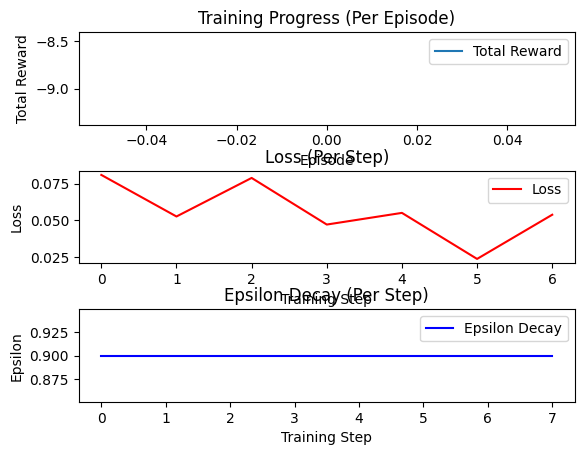

<Figure size 640x480 with 0 Axes>

1 / 300 , R=  -8.892216959684681
torch.Size([2, 18])
Loss: 0.060961574586317804
torch.Size([2, 18])
Loss: 0.08491462006998039
torch.Size([1, 18])
Loss: 2.456586017225638
torch.Size([1, 18])
Loss: 2.4713504677425364
torch.Size([2, 18])
Loss: 0.08496261142524514
torch.Size([2, 18])
Loss: 0.09135400828396159
torch.Size([2, 18])
Loss: 0.07733463463904677
torch.Size([2, 18])
Loss: 0.09879911963085912
2 / 300 , R=  -9.3098015482367
torch.Size([2, 18])
Loss: 0.04100938711662088
3 / 300 , R=  -5.271055215178098
torch.Size([2, 18])
Loss: 0.1072303523788708
torch.Size([1, 18])
Loss: 2.5804962675400587
torch.Size([2, 18])
Loss: 0.06677838822979529
torch.Size([2, 18])
Loss: 0.03235466739463264
torch.Size([2, 18])
Loss: 0.017990392010945322
torch.Size([2, 18])
Loss: 0.05024765500150705
torch.Size([2, 18])
Loss: 0.07722361130332735
4 / 300 , R=  -8.21789450703745
torch.Size([2, 18])
Loss: 0.09302264382654066
torch.Size([2, 18])
Loss: 0.0443860432534497
torch.Size([2, 18])
Loss: 0.02223057810991605
t

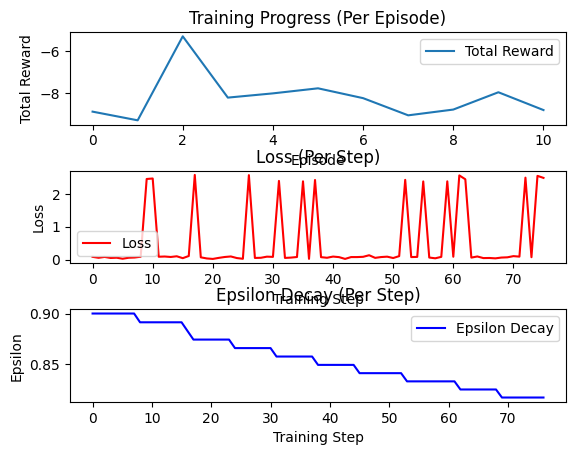

<Figure size 640x480 with 0 Axes>

11 / 300 , R=  -8.816506004441532
torch.Size([2, 18])
Loss: 0.0656879140414105
torch.Size([2, 18])
Loss: 0.06523184425523616
torch.Size([2, 18])
Loss: 0.1136974016692697
torch.Size([2, 18])
Loss: 0.07922321168657714
torch.Size([2, 18])
Loss: 0.049172291412843475
torch.Size([2, 18])
Loss: 0.024748160376238122
torch.Size([2, 18])
Loss: 0.09653337505655879
12 / 300 , R=  -7.449942362253764
torch.Size([2, 18])
Loss: 0.03243387715187203
torch.Size([1, 18])
Loss: 2.35888873933111
torch.Size([2, 18])
Loss: 0.0470635644054366
torch.Size([1, 18])
Loss: 2.5306779379924804
torch.Size([1, 18])
Loss: 2.3455183891288005
torch.Size([1, 18])
Loss: 2.4489975005219824
torch.Size([2, 18])
Loss: 0.08978461990629744
13 / 300 , R=  -6.62245143452661
torch.Size([2, 18])
Loss: 0.04869063395608776
torch.Size([2, 18])
Loss: 0.0713180828531099
torch.Size([2, 18])
Loss: 0.06555805321723025
torch.Size([2, 18])
Loss: 0.0924207869473379
torch.Size([2, 18])
Loss: 0.02467611686438464
torch.Size([1, 18])
Loss: 2.483117

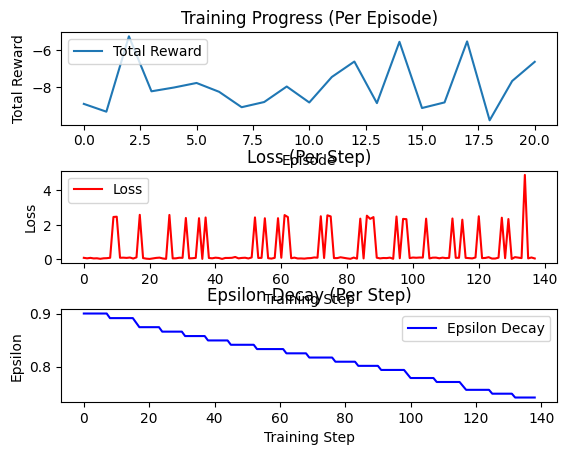

<Figure size 640x480 with 0 Axes>

21 / 300 , R=  -6.637261402624519
torch.Size([2, 18])
Loss: 0.0693017304398836
torch.Size([2, 18])
Loss: 0.03140468746115271
torch.Size([1, 18])
Loss: 2.3372397147115813
torch.Size([2, 18])
Loss: 0.08917092940366603
torch.Size([1, 18])
Loss: 2.3354155153141
torch.Size([2, 18])
Loss: 0.059988256392977744
torch.Size([2, 18])
Loss: 0.06631152486231301
22 / 300 , R=  -7.431084396733223
torch.Size([2, 18])
Loss: 0.05756454507748364
torch.Size([1, 18])
Loss: 2.388245885245503
torch.Size([2, 18])
Loss: 0.08693611692527775
torch.Size([2, 18])
Loss: 0.059573894917544806
torch.Size([2, 18])
Loss: 0.07087107153802655
torch.Size([2, 18])
Loss: 0.03243393741472965
torch.Size([1, 18])
Loss: 2.317993906410046
23 / 300 , R=  -7.811896938234425
torch.Size([2, 18])
Loss: 0.08013297437056671
torch.Size([1, 18])
Loss: 2.3217398100386784
torch.Size([2, 18])
Loss: 0.06343513679521624
torch.Size([1, 18])
Loss: 2.264026886447058
torch.Size([2, 18])
Loss: 0.07712952742713791
torch.Size([2, 18])
Loss: 0.0628911

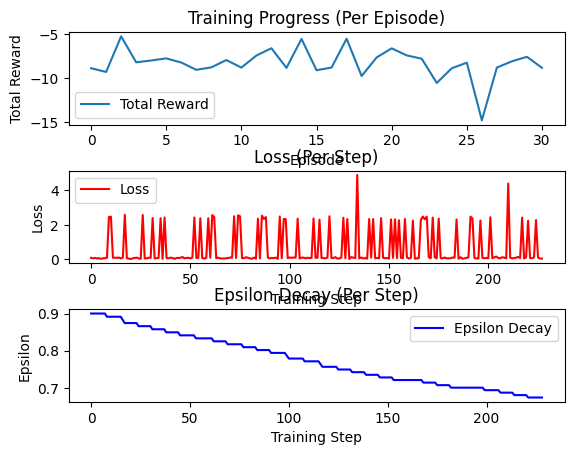

<Figure size 640x480 with 0 Axes>

31 / 300 , R=  -8.845996347815023
torch.Size([1, 18])
Loss: 2.3364996861678553
torch.Size([2, 18])
Loss: 0.1425895382654085
torch.Size([2, 18])
Loss: 0.07658986988067307
torch.Size([2, 18])
Loss: 0.08408187491572697
torch.Size([1, 18])
Loss: 2.225908689850804
torch.Size([2, 18])
Loss: 0.08359147889001833
torch.Size([1, 18])
Loss: 2.254894094430746
32 / 300 , R=  -8.88151096722353
torch.Size([1, 18])
Loss: 2.375501064465739
torch.Size([1, 18])
Loss: 2.1904499149346033
torch.Size([2, 18])
Loss: 0.09621442289803664
none occur
torch.Size([1, 18])
Loss: 4.354128379701729
torch.Size([2, 18])
Loss: 0.06590310930568814
torch.Size([2, 18])
Loss: 0.09626765618730056
torch.Size([2, 18])
Loss: 0.10008815790591333
33 / 300 , R=  -7.550295702207174
torch.Size([2, 18])
Loss: 0.0565815230304941
34 / 300 , R=  -5.458064986610573
torch.Size([1, 18])
Loss: 2.420476302958456
torch.Size([2, 18])
Loss: 0.09781698451057139
torch.Size([2, 18])
Loss: 0.1002229321095551
torch.Size([2, 18])
Loss: 0.1194573412501

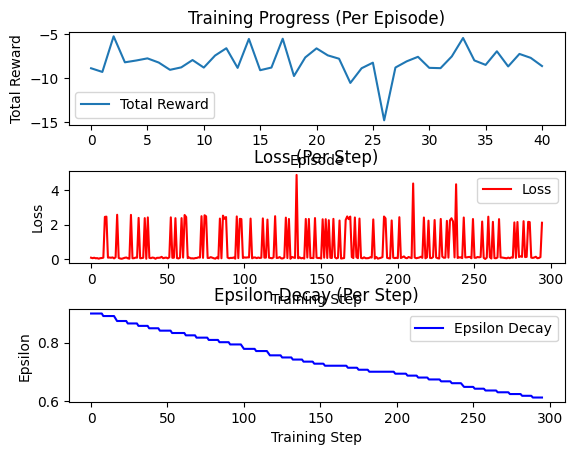

<Figure size 640x480 with 0 Axes>

41 / 300 , R=  -8.640675046418917
torch.Size([2, 18])
Loss: 0.07745790605968617
torch.Size([2, 18])
Loss: 0.14268652345654137
torch.Size([2, 18])
Loss: 0.095711655938745
torch.Size([2, 18])
Loss: 0.11903414855749567
torch.Size([1, 18])
Loss: 2.04285758890484
torch.Size([2, 18])
Loss: 0.0791707723652768
torch.Size([1, 18])
Loss: 2.016452060175557
torch.Size([2, 18])
Loss: 0.10005392555849091
42 / 300 , R=  -9.174913893056726
torch.Size([1, 18])
Loss: 2.19648290109071
torch.Size([2, 18])
Loss: 0.04358068767409313
torch.Size([2, 18])
Loss: 0.12104352646532703
torch.Size([2, 18])
Loss: 0.05646120845261264
torch.Size([2, 18])
Loss: 0.09693441993866629
torch.Size([2, 18])
Loss: 0.13749504444970567
torch.Size([2, 18])
Loss: 0.08457853039674472
torch.Size([2, 18])
Loss: 0.07731776578523197
43 / 300 , R=  -8.79734280142863
torch.Size([2, 18])
Loss: 0.045828698306952007
torch.Size([1, 18])
Loss: 2.0692905891004645
torch.Size([2, 18])
Loss: 0.08800501973925728
torch.Size([2, 18])
Loss: 0.08136942

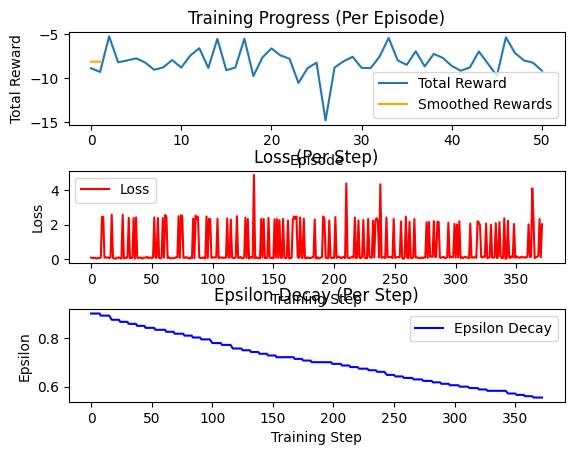

<Figure size 640x480 with 0 Axes>

51 / 300 , R=  -9.1719756003408
torch.Size([2, 18])
Loss: 0.036844174883796765
torch.Size([2, 18])
Loss: 0.08529627423575642
torch.Size([2, 18])
Loss: 0.13036523098260475
torch.Size([2, 18])
Loss: 0.12485024718380343
torch.Size([2, 18])
Loss: 0.095692732389988
torch.Size([1, 18])
Loss: 1.957881385384465
torch.Size([2, 18])
Loss: 0.0930486422146235
52 / 300 , R=  -6.89869464194636
torch.Size([1, 18])
Loss: 1.775788507411864
torch.Size([1, 18])
Loss: 1.8356308881359795
torch.Size([2, 18])
Loss: 0.09735877000252796
torch.Size([2, 18])
Loss: 0.08525693382837261
torch.Size([2, 18])
Loss: 0.1331672138154944
torch.Size([2, 18])
Loss: 0.1349030208494371
torch.Size([1, 18])
Loss: 1.957548321433959
torch.Size([1, 18])
Loss: 1.9542231610797047
53 / 300 , R=  -8.988230471784279
torch.Size([2, 18])
Loss: 0.06599206943880961
torch.Size([2, 18])
Loss: 0.07002146522549245
torch.Size([1, 18])
Loss: 1.956483397407618
torch.Size([2, 18])
Loss: 0.1616328210698155
torch.Size([1, 18])
Loss: 1.94317820816074

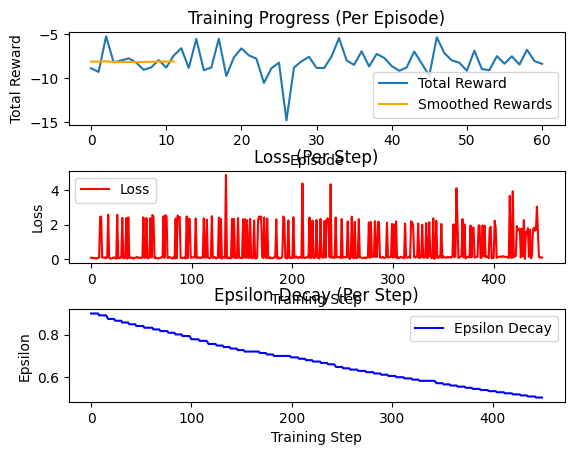

<Figure size 640x480 with 0 Axes>

61 / 300 , R=  -8.389514976571387
torch.Size([2, 18])
Loss: 0.10399882049345169
torch.Size([2, 18])
Loss: 0.071095132450531
torch.Size([2, 18])
Loss: 0.13733953950106298
torch.Size([2, 18])
Loss: 0.20289459320072958
torch.Size([2, 18])
Loss: 0.03188362962009107
torch.Size([2, 18])
Loss: 0.04348447596088422
torch.Size([1, 18])
Loss: 1.685546087347335
torch.Size([2, 18])
Loss: 0.14264141492969845
torch.Size([2, 18])
Loss: 0.06537512602872192
torch.Size([2, 18])
Loss: 0.0932202391040756
none occur
torch.Size([1, 18])
Loss: 3.1142374084556135
torch.Size([2, 18])
Loss: 0.06115784007470698
torch.Size([2, 18])
Loss: 0.09116366370167703
torch.Size([2, 18])
Loss: 0.16772811738092677
torch.Size([2, 18])
Loss: 0.05669817566987827
torch.Size([2, 18])
Loss: 0.10904764369282426
torch.Size([2, 18])
Loss: 0.14388168299665532
62 / 300 , R=  -11.729080851425252
torch.Size([2, 18])
Loss: 0.0910617242646901
torch.Size([1, 18])
Loss: 1.469610923670386
torch.Size([2, 18])
Loss: 0.12268438820345949
torch.Siz

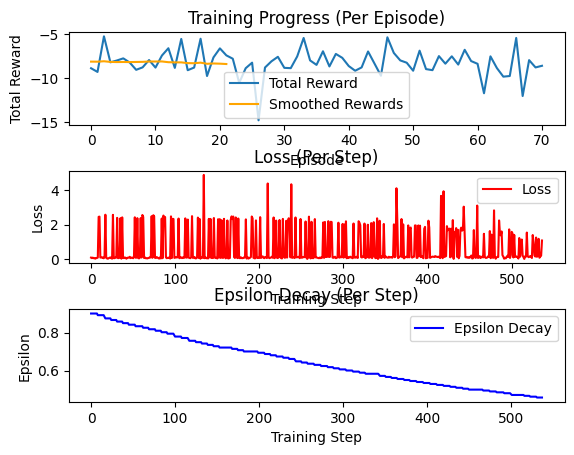

<Figure size 640x480 with 0 Axes>

71 / 300 , R=  -8.61266221471416
none occur
torch.Size([1, 18])
Loss: 3.407364854142625
torch.Size([2, 18])
Loss: 0.1514208892254125
torch.Size([1, 18])
Loss: 1.037474646040354
torch.Size([1, 18])
Loss: 1.1751072662917212
torch.Size([2, 18])
Loss: 0.24835706020768963
torch.Size([1, 18])
Loss: 1.1724451631721273
torch.Size([2, 18])
Loss: 0.2998011537725832
72 / 300 , R=  -8.878013985457406
torch.Size([2, 18])
Loss: 0.18110442168282453
torch.Size([2, 18])
Loss: 0.29418778617643676
torch.Size([2, 18])
Loss: 0.35386368301675597
torch.Size([2, 18])
Loss: 0.14075987377625532
torch.Size([2, 18])
Loss: 0.1961402447389567
torch.Size([2, 18])
Loss: 0.1488987756371965
torch.Size([2, 18])
Loss: 0.05391284665395533
torch.Size([2, 18])
Loss: 0.14452486316659305
73 / 300 , R=  -8.089469515300232
torch.Size([2, 18])
Loss: 0.07186202834900432
torch.Size([2, 18])
Loss: 0.09211815727117484
torch.Size([2, 18])
Loss: 0.07134669627531506
torch.Size([2, 18])
Loss: 0.1795250905439172
torch.Size([1, 18])
Loss:

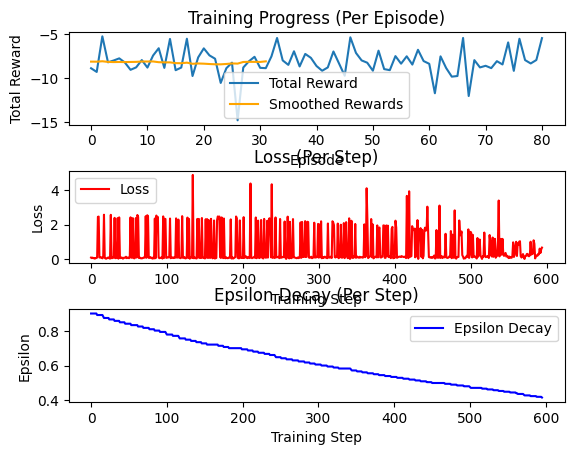

<Figure size 640x480 with 0 Axes>

81 / 300 , R=  -5.473434818465895
torch.Size([2, 18])
Loss: 0.24291032815147812
torch.Size([2, 18])
Loss: 0.33106297801011486
torch.Size([2, 18])
Loss: 0.05826749689227351
torch.Size([1, 18])
Loss: 0.7364085288539913
torch.Size([2, 18])
Loss: 0.06671353182824152
torch.Size([1, 18])
Loss: 0.7088995403876142
torch.Size([2, 18])
Loss: 0.18219240444192583
torch.Size([2, 18])
Loss: 0.39974635095223143
82 / 300 , R=  -9.290197043797589
torch.Size([2, 18])
Loss: 0.193514303223305
torch.Size([2, 18])
Loss: 0.1959879254087901
torch.Size([2, 18])
Loss: 0.39524767926586707
torch.Size([2, 18])
Loss: 0.49830530670233136
torch.Size([2, 18])
Loss: 0.1984289424679045
torch.Size([2, 18])
Loss: 0.35759938441306427
torch.Size([1, 18])
Loss: 0.5284342467286082
torch.Size([2, 18])
Loss: 0.037224973340455166
83 / 300 , R=  -8.823665478913501
torch.Size([2, 18])
Loss: 0.38442705387295417
torch.Size([2, 18])
Loss: 0.521669027102054
torch.Size([2, 18])
Loss: 0.3192565989482212
torch.Size([1, 18])
Loss: 0.46038

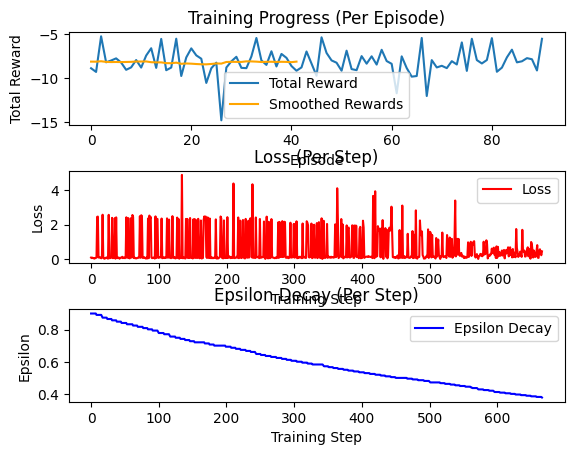

<Figure size 640x480 with 0 Axes>

91 / 300 , R=  -5.551549399618438
torch.Size([2, 18])
Loss: 0.3265497368643012
torch.Size([2, 18])
Loss: 0.682962378441174
torch.Size([2, 18])
Loss: 0.27388884388152895
torch.Size([1, 18])
Loss: 1.7294387427910438
torch.Size([2, 18])
Loss: 0.4192116860545045
torch.Size([1, 18])
Loss: 0.11642223205857552
torch.Size([2, 18])
Loss: 0.2598381047440886
92 / 300 , R=  -8.910150614273876
torch.Size([2, 18])
Loss: 0.12498422116411853
torch.Size([2, 18])
Loss: 0.8786232070136739
torch.Size([2, 18])
Loss: 0.3644888579524853
torch.Size([2, 18])
Loss: 0.2842064140061715
torch.Size([2, 18])
Loss: 0.3393124732980094
torch.Size([2, 18])
Loss: 0.40769072086238434
torch.Size([1, 18])
Loss: 0.09705019958397225
93 / 300 , R=  -8.35085936051822
torch.Size([2, 18])
Loss: 0.3921749521423441
torch.Size([2, 18])
Loss: 0.9563124554280851
torch.Size([2, 18])
Loss: 0.8162168901219076
torch.Size([2, 18])
Loss: 0.9783446769409041
torch.Size([1, 18])
Loss: 0.4439846609128783
torch.Size([2, 18])
Loss: 0.494747429743

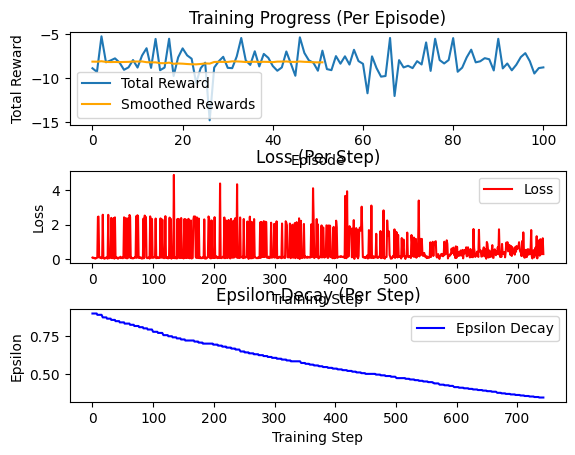

<Figure size 640x480 with 0 Axes>

101 / 300 , R=  -8.793552383949361
torch.Size([1, 18])
Loss: 1.5205539049558907
torch.Size([2, 18])
Loss: 0.4025240630047234
torch.Size([1, 18])
Loss: 0.5690728986626826
torch.Size([1, 18])
Loss: 0.6619665893055363
torch.Size([2, 18])
Loss: 0.8064937047678571
torch.Size([2, 18])
Loss: 0.30396737003234564
torch.Size([1, 18])
Loss: 1.3792089798634397
torch.Size([2, 18])
Loss: 0.45223632774183664
102 / 300 , R=  -8.012267532601735
torch.Size([2, 18])
Loss: 0.14525360905908324
torch.Size([2, 18])
Loss: 0.8631775998164897
torch.Size([1, 18])
Loss: 1.165997521514666
torch.Size([2, 18])
Loss: 0.5604958710857414
torch.Size([1, 18])
Loss: 1.151899737836213
torch.Size([2, 18])
Loss: 0.3318205795764514
torch.Size([2, 18])
Loss: 0.07359543904394739
torch.Size([2, 18])
Loss: 0.31411520960077627
103 / 300 , R=  -6.8153260141819185
torch.Size([1, 18])
Loss: 1.1314707449618022
torch.Size([2, 18])
Loss: 0.8419685009460703
torch.Size([2, 18])
Loss: 0.14653965886657455
torch.Size([2, 18])
Loss: 0.0227367

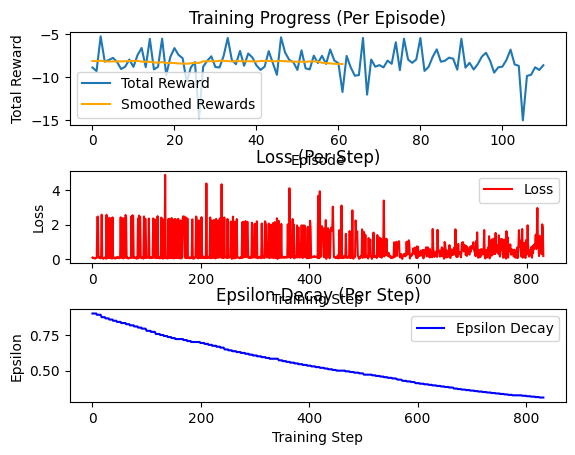

<Figure size 640x480 with 0 Axes>

111 / 300 , R=  -8.624241805994021
torch.Size([2, 18])
Loss: 0.042842325867349436
torch.Size([2, 18])
Loss: 0.4272857044639009
torch.Size([2, 18])
Loss: 0.6321505808688909
torch.Size([2, 18])
Loss: 0.07349832432567084
torch.Size([2, 18])
Loss: 0.7915303282059235
torch.Size([2, 18])
Loss: 0.2953891802217252
torch.Size([1, 18])
Loss: 2.771177382042618
torch.Size([2, 18])
Loss: 0.10250837225682669
112 / 300 , R=  -9.146065375929005
torch.Size([2, 18])
Loss: 0.8001439067496494
torch.Size([2, 18])
Loss: 1.5664147455494968
torch.Size([2, 18])
Loss: 0.08412155858574516
torch.Size([2, 18])
Loss: 0.6124922500284486
torch.Size([1, 18])
Loss: 1.0779036688469081
torch.Size([2, 18])
Loss: 0.7922666015100552
torch.Size([2, 18])
Loss: 0.8504156221032368
torch.Size([1, 18])
Loss: 2.2907637356788646
113 / 300 , R=  -9.61530885719647
torch.Size([2, 18])
Loss: 0.8877827852203936
torch.Size([2, 18])
Loss: 0.09676995884225215
torch.Size([1, 18])
Loss: 2.004380128102452
torch.Size([2, 18])
Loss: 0.570247449

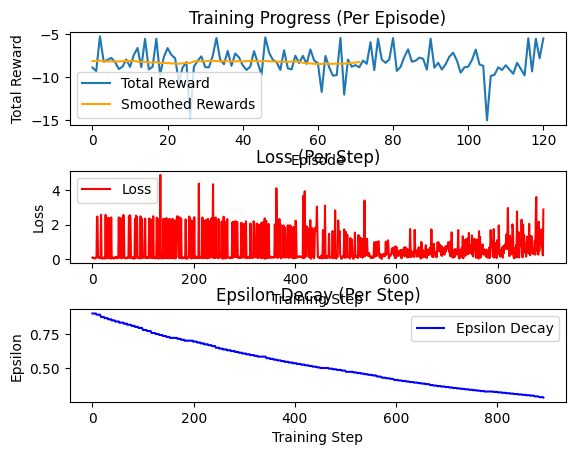

<Figure size 640x480 with 0 Axes>

121 / 300 , R=  -5.50080147022042
torch.Size([1, 18])
Loss: 1.831737812932945
none occur
torch.Size([1, 18])
Loss: 5.542005595932945
torch.Size([1, 18])
Loss: 3.1621150174360597
torch.Size([2, 18])
Loss: 0.3229056291818851
torch.Size([2, 18])
Loss: 0.3547733710511404
torch.Size([1, 18])
Loss: 2.3347205162059605
torch.Size([2, 18])
Loss: 1.0609088895391032
torch.Size([2, 18])
Loss: 0.5600724510232808
122 / 300 , R=  -9.157449507202987
torch.Size([2, 18])
Loss: 1.2907066616152947
torch.Size([2, 18])
Loss: 1.1659750344104909
torch.Size([1, 18])
Loss: 1.0175326232305115
torch.Size([2, 18])
Loss: 1.6431929697689474
torch.Size([2, 18])
Loss: 1.2394751717187673
torch.Size([1, 18])
Loss: 1.5110010415455755
torch.Size([2, 18])
Loss: 0.7685049129486519
torch.Size([1, 18])
Loss: 1.0788084836820653
123 / 300 , R=  -8.508681258705522
torch.Size([2, 18])
Loss: 0.6319011317101025
torch.Size([2, 18])
Loss: 1.231232600876343
torch.Size([2, 18])
Loss: 0.2502542754617285
torch.Size([2, 18])
Loss: 0.38485

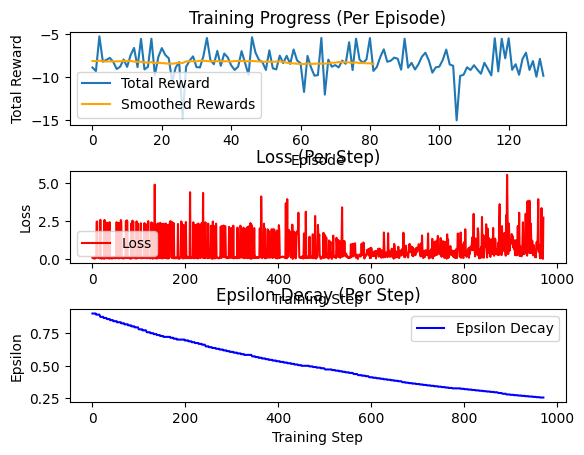

<Figure size 640x480 with 0 Axes>

131 / 300 , R=  -9.853791914341492
torch.Size([1, 18])
Loss: 4.15136698450407
torch.Size([2, 18])
Loss: 0.4548284498111581
torch.Size([2, 18])
Loss: 0.5068294238361022
torch.Size([1, 18])
Loss: 4.8432014747235215
torch.Size([1, 18])
Loss: 3.8651248967573872
torch.Size([2, 18])
Loss: 0.007334573303253738
torch.Size([2, 18])
Loss: 1.3952890859412967
torch.Size([2, 18])
Loss: 1.299232608984819
132 / 300 , R=  -7.071393959404884
torch.Size([2, 18])
Loss: 0.7324747977863693
torch.Size([1, 18])
Loss: 3.3854914269590037
torch.Size([2, 18])
Loss: 1.0689197424550962
torch.Size([1, 18])
Loss: 4.809350075739028
torch.Size([1, 18])
Loss: 2.6827558746026483
torch.Size([2, 18])
Loss: 1.412686296144377
torch.Size([2, 18])
Loss: 0.38856024034472314
torch.Size([2, 18])
Loss: 1.166081159383702
133 / 300 , R=  -9.896806418999933
torch.Size([2, 18])
Loss: 0.4887284786770545
torch.Size([2, 18])
Loss: 0.10614228696965092
torch.Size([2, 18])
Loss: 2.0510546352097063
torch.Size([2, 18])
Loss: 0.79961604724018

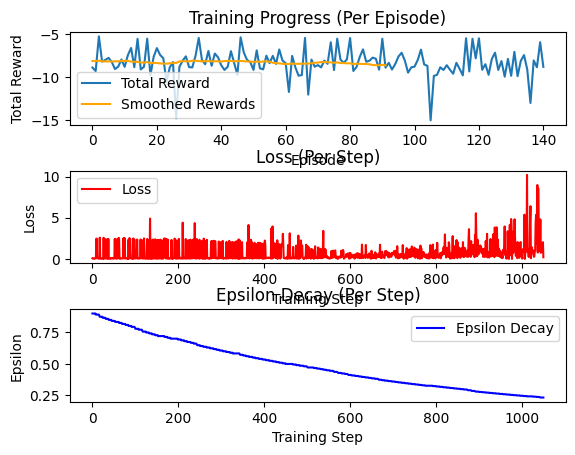

<Figure size 640x480 with 0 Axes>

141 / 300 , R=  -8.817795179472984
torch.Size([2, 18])
Loss: 0.037981700914849474
torch.Size([1, 18])
Loss: 4.0802893536078715
torch.Size([2, 18])
Loss: 0.9810987920897754
torch.Size([2, 18])
Loss: 2.4371435758040274
torch.Size([1, 18])
Loss: 3.663142947848479
torch.Size([2, 18])
Loss: 0.41019922121734853
torch.Size([2, 18])
Loss: 0.6521569393176125
142 / 300 , R=  -9.113781395502345
torch.Size([2, 18])
Loss: 0.8620800329128775
torch.Size([2, 18])
Loss: 2.0860813996787435
torch.Size([2, 18])
Loss: 1.5391672910463567
torch.Size([2, 18])
Loss: 0.42447585841048036
torch.Size([2, 18])
Loss: 1.159616191638663
torch.Size([2, 18])
Loss: 0.2991722455617136
torch.Size([2, 18])
Loss: 2.0552535420010267
torch.Size([2, 18])
Loss: 1.2349049206798766
torch.Size([2, 18])
Loss: 0.5889441739938799
torch.Size([2, 18])
Loss: 0.9861250170348771
torch.Size([1, 18])
Loss: 6.074564999083293
torch.Size([1, 18])
Loss: 4.799715362921403
torch.Size([2, 18])
Loss: 1.3015246249114751
torch.Size([1, 18])
Loss: 5.31

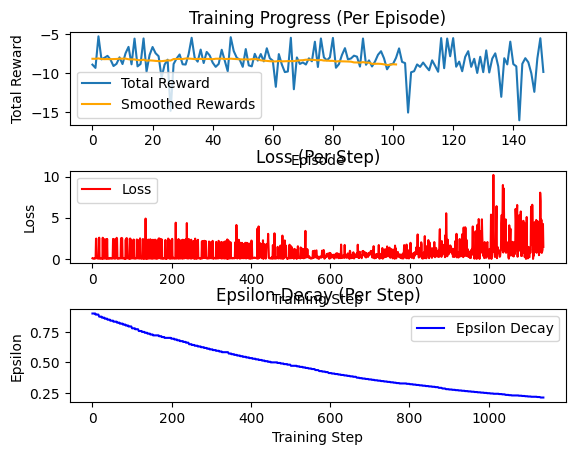

<Figure size 640x480 with 0 Axes>

151 / 300 , R=  -9.82455918641094
torch.Size([1, 18])
Loss: 6.851527092870143
torch.Size([2, 18])
Loss: 0.21887220829863563
torch.Size([2, 18])
Loss: 1.3461248837613948
torch.Size([2, 18])
Loss: 1.2783009528252118
torch.Size([2, 18])
Loss: 0.34638910840615816
torch.Size([2, 18])
Loss: 0.06788761179400002
torch.Size([2, 18])
Loss: 0.03056447243904281
torch.Size([2, 18])
Loss: 0.46154011680174795
152 / 300 , R=  -7.03156335143045
torch.Size([1, 18])
Loss: 5.968718628567478
torch.Size([2, 18])
Loss: 1.0994162944743093
torch.Size([1, 18])
Loss: 4.9200634277641
torch.Size([2, 18])
Loss: 1.4771053866391037
torch.Size([2, 18])
Loss: 2.270853816392049
torch.Size([2, 18])
Loss: 0.8265668399807234
torch.Size([1, 18])
Loss: 4.083967030232635
torch.Size([2, 18])
Loss: 0.196133116912717
153 / 300 , R=  -9.981876310284127
torch.Size([2, 18])
Loss: 0.6508496991913325
torch.Size([1, 18])
Loss: 6.1327470566334465
torch.Size([2, 18])
Loss: 0.6702848918719035
torch.Size([2, 18])
Loss: 0.6395309299737341


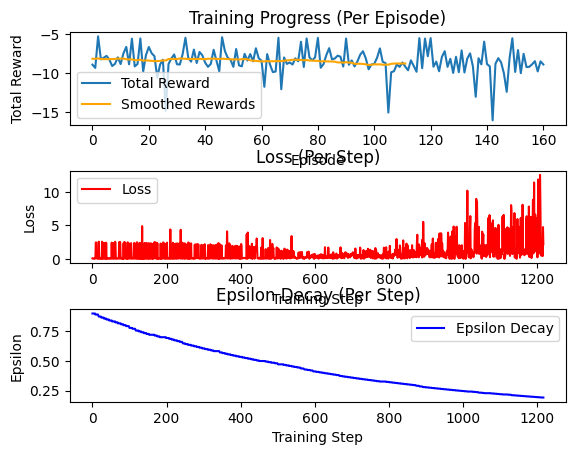

<Figure size 640x480 with 0 Axes>

161 / 300 , R=  -8.87000526347165
torch.Size([2, 18])
Loss: 0.8330011023992492
torch.Size([1, 18])
Loss: 6.626838465902504
torch.Size([1, 18])
Loss: 4.607905720416445
none occur
torch.Size([1, 18])
Loss: 10.30262015919411
torch.Size([2, 18])
Loss: 2.170131403273431
torch.Size([2, 18])
Loss: 3.4536147393936307
torch.Size([2, 18])
Loss: 1.922709713096161
torch.Size([1, 18])
Loss: 6.869766027463868
162 / 300 , R=  -9.120132671500118
torch.Size([2, 18])
Loss: 0.5278117874191963
163 / 300 , R=  -5.396902149973535
torch.Size([1, 18])
Loss: 4.765764815941757
torch.Size([1, 18])
Loss: 4.418343839899871
torch.Size([2, 18])
Loss: 1.5141010056684658
torch.Size([2, 18])
Loss: 0.5434044680150709
torch.Size([2, 18])
Loss: 1.4495734188220748
torch.Size([2, 18])
Loss: 2.1206568623469266
torch.Size([2, 18])
Loss: 0.8171866051714931
164 / 300 , R=  -7.388678458719408
torch.Size([2, 18])
Loss: 1.4420413117692703
torch.Size([2, 18])
Loss: 3.247525210410373
torch.Size([1, 18])
Loss: 5.94798504750631
torch.

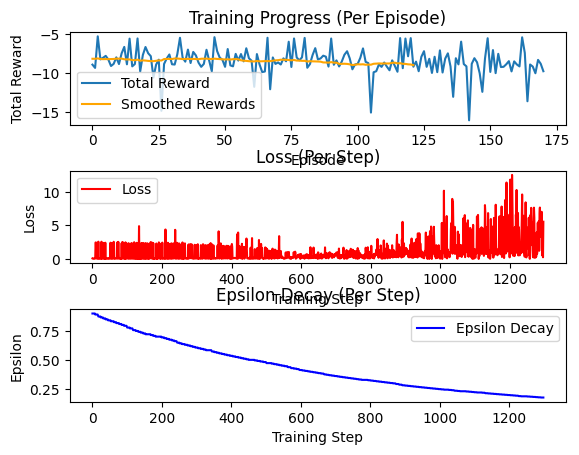

<Figure size 640x480 with 0 Axes>

171 / 300 , R=  -9.735530907234171
torch.Size([2, 18])
Loss: 0.6101233487908813
torch.Size([1, 18])
Loss: 5.108503826244783
torch.Size([2, 18])
Loss: 1.6474615750871497
torch.Size([2, 18])
Loss: 0.12258489548622487
torch.Size([2, 18])
Loss: 1.5801588137746885
torch.Size([1, 18])
Loss: 1.3814399965454425
torch.Size([2, 18])
Loss: 1.1930949716329746
torch.Size([2, 18])
Loss: 0.21043457774288016
172 / 300 , R=  -9.54277959843968
torch.Size([2, 18])
Loss: 0.6215530768249071
torch.Size([2, 18])
Loss: 1.3402900897422834
torch.Size([2, 18])
Loss: 0.22699508624241244
torch.Size([2, 18])
Loss: 1.3842086217718474
torch.Size([2, 18])
Loss: 2.1870682101783014
torch.Size([2, 18])
Loss: 0.5613800748565392
torch.Size([2, 18])
Loss: 0.925657064911749
torch.Size([2, 18])
Loss: 0.22485263707486333
173 / 300 , R=  -8.830060640105378
torch.Size([2, 18])
Loss: 1.5009588080302123
torch.Size([2, 18])
Loss: 4.429486312318653
torch.Size([2, 18])
Loss: 0.11964021271037505
torch.Size([1, 18])
Loss: 11.5298111392

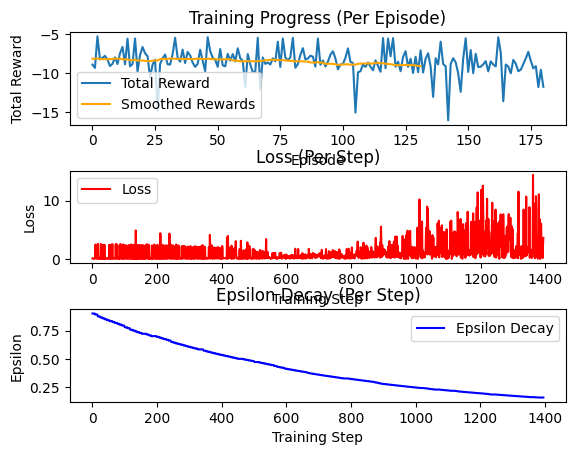

<Figure size 640x480 with 0 Axes>

181 / 300 , R=  -11.73159310965541
torch.Size([2, 18])
Loss: 0.07383643318917954
torch.Size([2, 18])
Loss: 0.4841205001547789
torch.Size([2, 18])
Loss: 2.6181471834766663
torch.Size([2, 18])
Loss: 2.9220120874033224
torch.Size([2, 18])
Loss: 3.097302903642948
torch.Size([1, 18])
Loss: 7.664086296960016
torch.Size([2, 18])
Loss: 0.24407739393822403
torch.Size([1, 18])
Loss: 7.5155556209084455
182 / 300 , R=  -9.312900685681495
torch.Size([1, 18])
Loss: 8.103129845706322
torch.Size([2, 18])
Loss: 1.5456891751649557
torch.Size([2, 18])
Loss: 2.7617658114116566
torch.Size([1, 18])
Loss: 8.484872970587135
torch.Size([2, 18])
Loss: 1.0538707039590036
torch.Size([2, 18])
Loss: 0.42819144553691013
torch.Size([1, 18])
Loss: 8.799879186156792
torch.Size([2, 18])
Loss: 0.048697693070246614
183 / 300 , R=  -8.04544518173886
torch.Size([2, 18])
Loss: 1.8876039452996372
torch.Size([1, 18])
Loss: 8.391082977555717
torch.Size([1, 18])
Loss: 7.709046768198174
torch.Size([2, 18])
Loss: 0.040955364199756

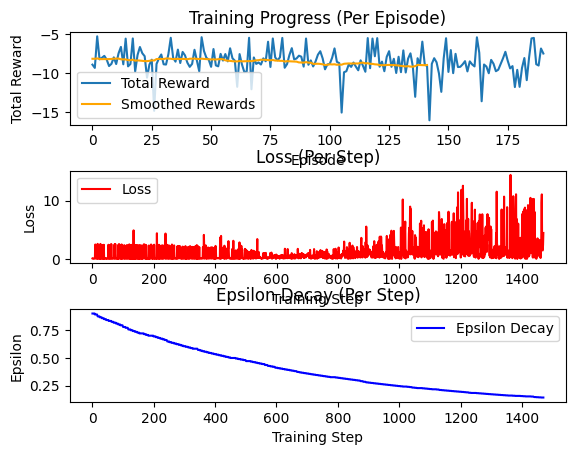

<Figure size 640x480 with 0 Axes>

191 / 300 , R=  -7.470665656228292
torch.Size([2, 18])
Loss: 1.4303566878031195
torch.Size([2, 18])
Loss: 1.1469847302719387
torch.Size([2, 18])
Loss: 1.621150528466944
torch.Size([2, 18])
Loss: 2.5460805509242643
torch.Size([2, 18])
Loss: 1.7139710853769143
torch.Size([2, 18])
Loss: 1.6105649810484164
torch.Size([2, 18])
Loss: 0.8356996040074414
torch.Size([1, 18])
Loss: 12.402624141648978
192 / 300 , R=  -9.26197354009622
torch.Size([2, 18])
Loss: 2.2891119686259906
torch.Size([2, 18])
Loss: 1.483310100444215
torch.Size([2, 18])
Loss: 0.48626299167619386
torch.Size([1, 18])
Loss: 2.1176677633481433
torch.Size([2, 18])
Loss: 0.304116471098276
torch.Size([2, 18])
Loss: 2.6818889592352373
torch.Size([1, 18])
Loss: 10.480316650906314
torch.Size([1, 18])
Loss: 12.488803268454168
193 / 300 , R=  -9.558042263682118
torch.Size([2, 18])
Loss: 1.198408043752584
torch.Size([1, 18])
Loss: 1.920694411548883
torch.Size([2, 18])
Loss: 2.947769644221494
torch.Size([2, 18])
Loss: 2.094232190713388
to

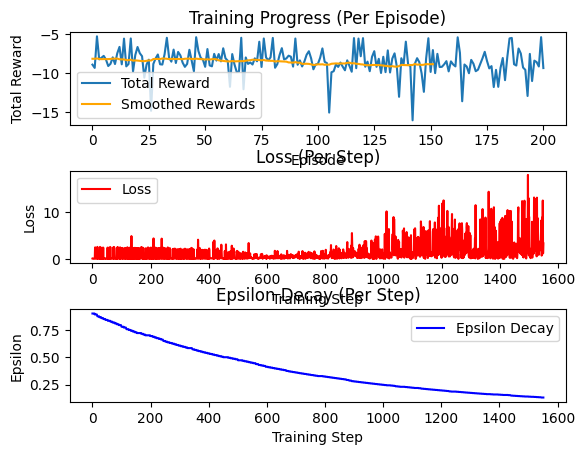

<Figure size 640x480 with 0 Axes>

201 / 300 , R=  -9.3294880354717
torch.Size([2, 18])
Loss: 2.3034470564588956
torch.Size([2, 18])
Loss: 5.5695551277874324
torch.Size([1, 18])
Loss: 8.16355511398827
torch.Size([1, 18])
Loss: 13.604911662399473
torch.Size([2, 18])
Loss: 0.29059478989867105
torch.Size([2, 18])
Loss: 2.2043808219376295
torch.Size([1, 18])
Loss: 9.981656515890766
torch.Size([2, 18])
Loss: 1.5284334220009974
torch.Size([2, 18])
Loss: 0.05146154174564272
torch.Size([1, 18])
Loss: 11.56850851278371
torch.Size([2, 18])
Loss: 0.22536193525559864
torch.Size([1, 18])
Loss: 9.280821827123816
torch.Size([2, 18])
Loss: 3.3340065086593187
202 / 300 , R=  -9.623712805270637
torch.Size([1, 18])
Loss: 10.872891542422334
torch.Size([1, 18])
Loss: 7.30585072779066
torch.Size([2, 18])
Loss: 0.3229933983121433
torch.Size([1, 18])
Loss: 9.679543197841868
torch.Size([1, 18])
Loss: 2.193158386512051
torch.Size([2, 18])
Loss: 0.3072892052074433
torch.Size([2, 18])
Loss: 0.841924121419094
203 / 300 , R=  -7.441316702838124
torc

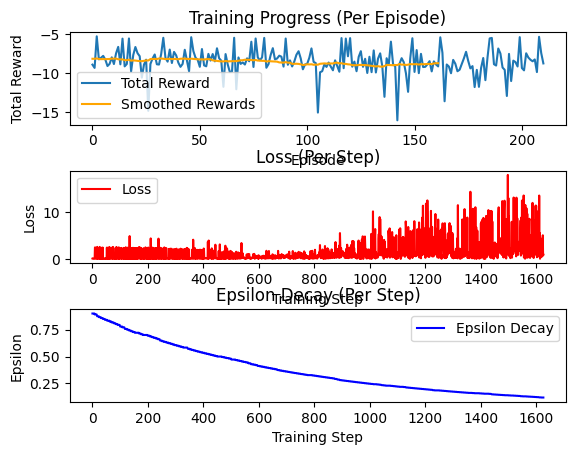

<Figure size 640x480 with 0 Axes>

211 / 300 , R=  -8.73673157058607
torch.Size([2, 18])
Loss: 3.701142719847045
torch.Size([1, 18])
Loss: 9.371886422335631
torch.Size([2, 18])
Loss: 2.1348420157752397
torch.Size([2, 18])
Loss: 0.26763115179608504
torch.Size([2, 18])
Loss: 3.45264289824536
torch.Size([2, 18])
Loss: 0.6209764445486223
torch.Size([2, 18])
Loss: 0.4430269637821381
torch.Size([2, 18])
Loss: 2.9395591833363635
212 / 300 , R=  -8.256100990056265
torch.Size([2, 18])
Loss: 1.7062428596339219
torch.Size([2, 18])
Loss: 3.1680942873779347
torch.Size([2, 18])
Loss: 1.159266297436087
torch.Size([2, 18])
Loss: 3.0675919126987523
torch.Size([1, 18])
Loss: 15.35327573407439
torch.Size([1, 18])
Loss: 8.662805194919311
torch.Size([2, 18])
Loss: 0.7439631201924924
213 / 300 , R=  -7.908455974659551
torch.Size([1, 18])
Loss: 8.77167151127198
torch.Size([1, 18])
Loss: 2.75638650183339
none occur
torch.Size([1, 18])
Loss: 24.800562480718114
214 / 300 , R=  -6.671958846792242
torch.Size([1, 18])
Loss: 17.542845196075486
torch

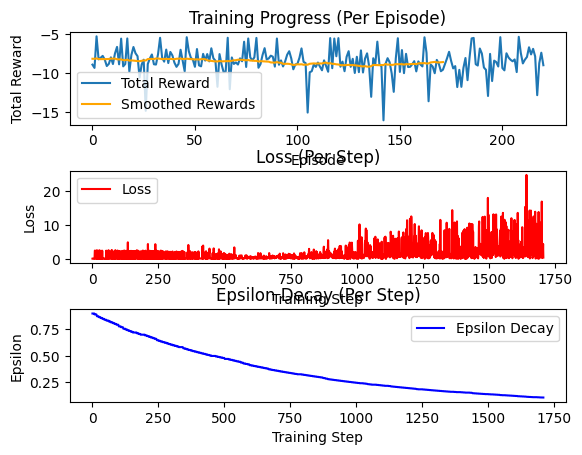

<Figure size 640x480 with 0 Axes>

221 / 300 , R=  -8.967424533962053
torch.Size([2, 18])
Loss: 0.686458055978732
torch.Size([2, 18])
Loss: 3.110600877520829
222 / 300 , R=  -6.126461420572779
torch.Size([2, 18])
Loss: 0.8379342248238402
torch.Size([2, 18])
Loss: 1.5051755564177012
torch.Size([2, 18])
Loss: 2.1058701738019145
torch.Size([1, 18])
Loss: 16.484777768840253
torch.Size([1, 18])
Loss: 12.410538800721378
torch.Size([1, 18])
Loss: 14.110315706822064
torch.Size([2, 18])
Loss: 0.7257818026519264
torch.Size([2, 18])
Loss: 3.9880652238837833
223 / 300 , R=  -8.160905930395
torch.Size([1, 18])
Loss: 18.262652748306422
torch.Size([2, 18])
Loss: 2.16859640914652
torch.Size([2, 18])
Loss: 2.01683721850858
torch.Size([2, 18])
Loss: 2.1575844991073225
torch.Size([2, 18])
Loss: 2.239138398513025
torch.Size([2, 18])
Loss: 1.8623280926476438
torch.Size([2, 18])
Loss: 5.742524220959464
torch.Size([2, 18])
Loss: 6.749331124581305
224 / 300 , R=  -8.63885853817711
torch.Size([2, 18])
Loss: 2.1289872271346875
torch.Size([2, 18]

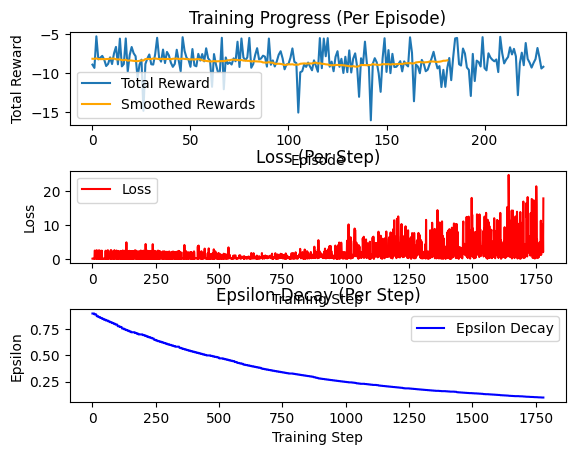

<Figure size 640x480 with 0 Axes>

231 / 300 , R=  -9.164815625219006
torch.Size([2, 18])
Loss: 0.7130081912070905
torch.Size([2, 18])
Loss: 6.057714533744015
torch.Size([2, 18])
Loss: 2.5460777209559895
torch.Size([2, 18])
Loss: 4.893829414068547
torch.Size([1, 18])
Loss: 19.870270033310113
torch.Size([1, 18])
Loss: 12.605373490555197
torch.Size([2, 18])
Loss: 2.0474377578596883
torch.Size([2, 18])
Loss: 0.20257626478161417
232 / 300 , R=  -7.812328294560457
torch.Size([2, 18])
Loss: 0.20470230015220173
torch.Size([1, 18])
Loss: 16.543971035817897
torch.Size([2, 18])
Loss: 0.8106668040046472
torch.Size([2, 18])
Loss: 7.171261443561448
torch.Size([2, 18])
Loss: 7.239800926757573
torch.Size([2, 18])
Loss: 2.8446867082158214
torch.Size([2, 18])
Loss: 1.3323994707444768
torch.Size([2, 18])
Loss: 3.4034178956999828
233 / 300 , R=  -7.8676794696054975
torch.Size([2, 18])
Loss: 4.417074066860744
234 / 300 , R=  -5.554532345384251
torch.Size([2, 18])
Loss: 0.6360858651833237
torch.Size([2, 18])
Loss: 4.357986705693593
torch.Si

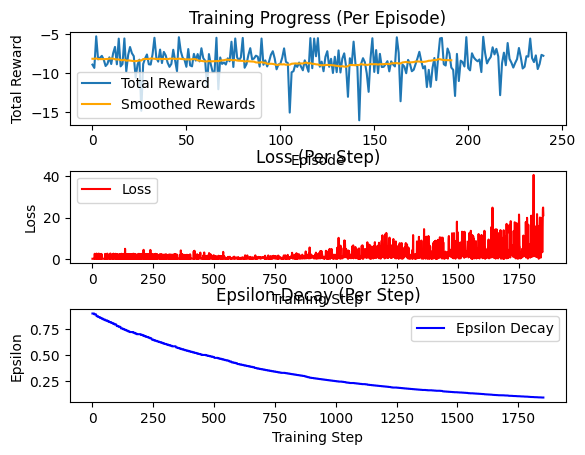

<Figure size 640x480 with 0 Axes>

241 / 300 , R=  -7.756120900423214
torch.Size([2, 18])
Loss: 3.1046188464520093
242 / 300 , R=  -5.514158854521425
torch.Size([2, 18])
Loss: 4.802488297182346
torch.Size([1, 18])
Loss: 22.11914279651077
torch.Size([2, 18])
Loss: 2.6187089460429025
torch.Size([2, 18])
Loss: 3.6269597621937963
torch.Size([1, 18])
Loss: 21.71627208106679
torch.Size([1, 18])
Loss: 20.079723100348488
torch.Size([1, 18])
Loss: 11.68153144321479
torch.Size([2, 18])
Loss: 2.5133281222279713
243 / 300 , R=  -8.52676146046754
torch.Size([2, 18])
Loss: 1.263362235368243
torch.Size([2, 18])
Loss: 0.5633875170340581
torch.Size([2, 18])
Loss: 6.876735075962166
torch.Size([1, 18])
Loss: 21.484405359891493
torch.Size([2, 18])
Loss: 2.343325585640272
torch.Size([2, 18])
Loss: 0.5493755360825544
torch.Size([2, 18])
Loss: 1.0623028146715399
torch.Size([1, 18])
Loss: 12.734454272535535
244 / 300 , R=  -8.651283194362751
torch.Size([2, 18])
Loss: 2.04039920742584
torch.Size([2, 18])
Loss: 3.109787931275067
torch.Size([2, 1

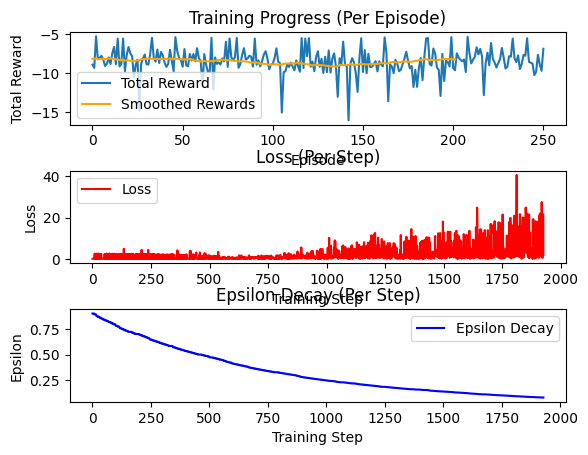

<Figure size 640x480 with 0 Axes>

251 / 300 , R=  -6.863586026208176
torch.Size([2, 18])
Loss: 0.34978959412993177
torch.Size([2, 18])
Loss: 2.1743101717953133
torch.Size([2, 18])
Loss: 2.739373133578683
torch.Size([2, 18])
Loss: 1.1166989244291479
torch.Size([2, 18])
Loss: 0.8060771367260529
torch.Size([2, 18])
Loss: 1.0594408552916472
none occur
torch.Size([1, 18])
Loss: 29.02776911070911
torch.Size([1, 18])
Loss: 31.031503816029822
252 / 300 , R=  -7.4305825495780615
torch.Size([2, 18])
Loss: 2.1359922294279605
torch.Size([2, 18])
Loss: 5.192184792677331
torch.Size([2, 18])
Loss: 8.938077629906882
torch.Size([1, 18])
Loss: 23.160262938782225
torch.Size([1, 18])
Loss: 21.140893263527076
torch.Size([2, 18])
Loss: 2.103481474404834
torch.Size([2, 18])
Loss: 4.737331913730658
torch.Size([2, 18])
Loss: 3.857052189080795
253 / 300 , R=  -8.87793108564712
torch.Size([2, 18])
Loss: 3.0995830753808056
torch.Size([2, 18])
Loss: 4.756058324142174
torch.Size([2, 18])
Loss: 5.484360310510105
torch.Size([2, 18])
Loss: 3.275990818

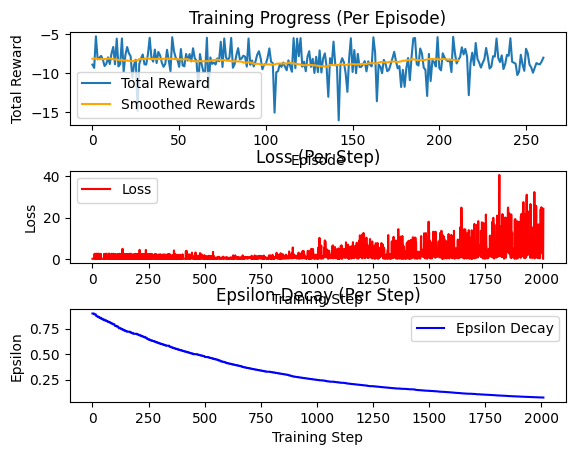

<Figure size 640x480 with 0 Axes>

261 / 300 , R=  -8.001229350878905
torch.Size([2, 18])
Loss: 7.328874476201625
torch.Size([1, 18])
Loss: 15.512855937945126
torch.Size([1, 18])
Loss: 24.367656701404414
torch.Size([1, 18])
Loss: 20.126151468752546
torch.Size([2, 18])
Loss: 2.5081786926258296
torch.Size([2, 18])
Loss: 0.47532128632932763
torch.Size([1, 18])
Loss: 24.78671376584894
torch.Size([2, 18])
Loss: 5.27463450334168
262 / 300 , R=  -9.173761250685915
torch.Size([1, 18])
Loss: 14.240217604111454
torch.Size([2, 18])
Loss: 6.69438801420965
torch.Size([2, 18])
Loss: 7.108581652559632
torch.Size([2, 18])
Loss: 7.616840305501665
torch.Size([2, 18])
Loss: 2.395066967084258
torch.Size([1, 18])
Loss: 19.744342101357
torch.Size([2, 18])
Loss: 2.514053181780678
torch.Size([2, 18])
Loss: 2.2463421927410394
263 / 300 , R=  -8.840074116684919
torch.Size([1, 18])
Loss: 26.153511097458694
torch.Size([2, 18])
Loss: 3.460971154936418
torch.Size([1, 18])
Loss: 16.761676643766737
torch.Size([2, 18])
Loss: 0.44523336074437514
torch.S

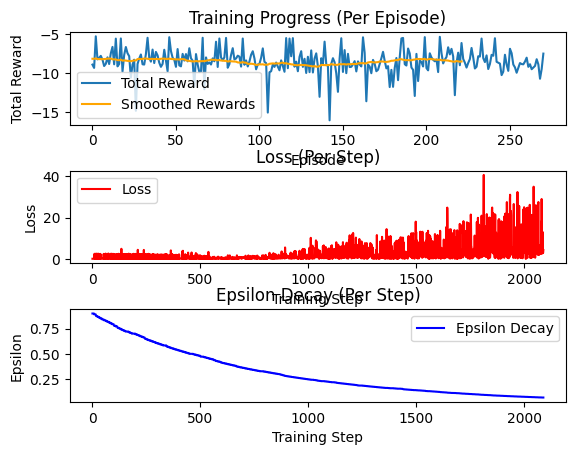

<Figure size 640x480 with 0 Axes>

271 / 300 , R=  -7.480898308725863
torch.Size([1, 18])
Loss: 27.78892840032179
torch.Size([2, 18])
Loss: 2.0893695745554517
torch.Size([2, 18])
Loss: 3.4153219454597163
torch.Size([2, 18])
Loss: 1.0104868818971084
torch.Size([2, 18])
Loss: 0.6965152495261883
torch.Size([1, 18])
Loss: 29.170336868396372
torch.Size([2, 18])
Loss: 6.6421386983003305
torch.Size([2, 18])
Loss: 0.9299606090791354
272 / 300 , R=  -9.170935825965682
torch.Size([2, 18])
Loss: 9.061161411357537
torch.Size([2, 18])
Loss: 5.350156690335897
torch.Size([2, 18])
Loss: 8.028724308186213
torch.Size([2, 18])
Loss: 0.26288153094256544
torch.Size([2, 18])
Loss: 5.802833636548369
torch.Size([2, 18])
Loss: 6.510939072359305
torch.Size([2, 18])
Loss: 1.992387661243324
torch.Size([1, 18])
Loss: 32.341068524138336
273 / 300 , R=  -9.10907995111674
torch.Size([1, 18])
Loss: 19.990375610279248
torch.Size([1, 18])
Loss: 21.202799977151997
torch.Size([2, 18])
Loss: 7.208406842564127
torch.Size([2, 18])
Loss: 9.024057000625918
none

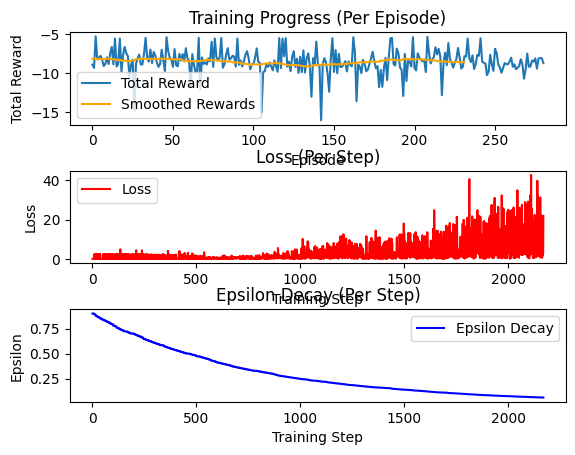

<Figure size 640x480 with 0 Axes>

281 / 300 , R=  -8.685373763885249
torch.Size([2, 18])
Loss: 14.240492781091255
torch.Size([2, 18])
Loss: 2.6465858640527014
torch.Size([2, 18])
Loss: 6.884621589087079
torch.Size([2, 18])
Loss: 3.3091504744706626
torch.Size([1, 18])
Loss: 22.097037891995768
torch.Size([2, 18])
Loss: 4.01708019229471
torch.Size([2, 18])
Loss: 0.5487899423929301
torch.Size([2, 18])
Loss: 3.1302240304649147
282 / 300 , R=  -7.55719570595791
torch.Size([1, 18])
Loss: 19.001166621716973
torch.Size([1, 18])
Loss: 23.941755646373146
torch.Size([2, 18])
Loss: 0.796710446829754
torch.Size([2, 18])
Loss: 2.8692576449165443
torch.Size([2, 18])
Loss: 4.867623937366673
torch.Size([2, 18])
Loss: 7.92211838891024
torch.Size([2, 18])
Loss: 7.003589332326779
torch.Size([2, 18])
Loss: 5.746503583629639
283 / 300 , R=  -9.478781718899588
torch.Size([2, 18])
Loss: 0.29934952054683817
torch.Size([2, 18])
Loss: 6.132448749190269
torch.Size([2, 18])
Loss: 1.4731049481176868
torch.Size([2, 18])
Loss: 0.843060590315293
torch.

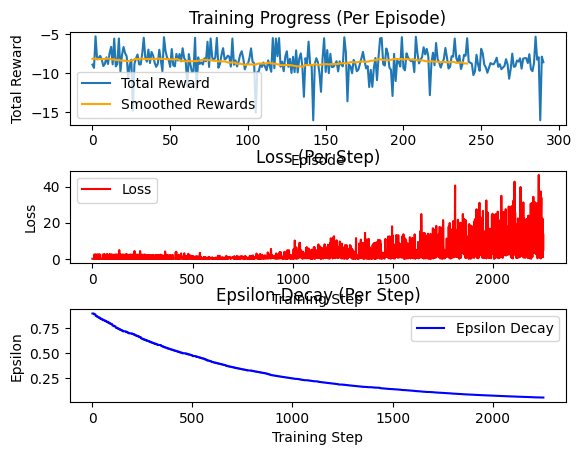

<Figure size 640x480 with 0 Axes>

291 / 300 , R=  -8.585744649445054
torch.Size([2, 18])
Loss: 0.479956312546768
torch.Size([2, 18])
Loss: 1.6285609848914027
torch.Size([2, 18])
Loss: 13.230553391464966
torch.Size([2, 18])
Loss: 2.2512041013212105
torch.Size([2, 18])
Loss: 2.171536394400377
torch.Size([2, 18])
Loss: 7.225867311102174
torch.Size([1, 18])
Loss: 29.467464441329614
torch.Size([1, 18])
Loss: 31.861052562692056
292 / 300 , R=  -9.228102656154556
torch.Size([2, 18])
Loss: 9.45911239156549
torch.Size([2, 18])
Loss: 3.472771036057612
torch.Size([2, 18])
Loss: 4.459869492177521
torch.Size([2, 18])
Loss: 0.6432771445352958
torch.Size([1, 18])
Loss: 28.01408219398548
torch.Size([2, 18])
Loss: 11.756192598837998
torch.Size([1, 18])
Loss: 8.8922831458492
torch.Size([2, 18])
Loss: 5.403873630094896
293 / 300 , R=  -9.3683828247157
torch.Size([1, 18])
Loss: 25.047033801708764
torch.Size([2, 18])
Loss: 7.045239602493741
torch.Size([1, 18])
Loss: 25.34838168020502
torch.Size([2, 18])
Loss: 4.284794475906507
torch.Size([

<Figure size 640x480 with 0 Axes>

In [54]:
for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    observation, info = env.reset()
    observation_vector = process_observation(observation)
    observation_tensor = torch.tensor(observation_vector, dtype=torch.float32, device=device).unsqueeze(0)
    
    total_reward = 0  # Track total reward for this episode

    for t in count():
        action = select_action(observation_tensor,i_episode)
        observation, reward, done, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        total_reward += reward.item()  # Accumulate rewards

        if done:
            next_state = None
        else:
            observation_vector = process_observation(observation)
            next_state = torch.tensor(observation_vector, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(observation_tensor, action, next_state, reward)

        # Move to the next state
        observation_tensor = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_policy_net()

        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(total_reward)  # Save total reward for this episode
            if i_episode % 10 == 0:
                plot_training_durations()
            break

        # Update target network (weights)
        if t % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
    
    print(i_episode + 1,'/',num_episodes, ', R= ', episode_rewards[i_episode])

print('Training is finished')
plt.ioff()
plt.show()

In [55]:
# # Initialize the environment and get its state
# observation, info = env.reset()
# observation_vector = process_observation(observation)
# observation_tensor = torch.tensor(observation_vector, dtype=torch.float32, device=device).unsqueeze(0)
# print(observation_tensor.shape)
# print(info)

# action = select_action(observation_tensor,i_episode)
# print(action)

# observation, reward, done, truncated, _ = env.step(action.item())
# print(observation)
# print(done)

# reward = torch.tensor([reward], device=device)
# print(reward)
# out = env.compute_reward(observation["achieved_goal"],observation["desired_goal"],{})
# print(out > -env.config["success_goal_reward"])

In [56]:
env.close()

In [57]:
print(torch.zeros(torch.Size([1, 18])))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
